# Lab Assignment Four: Multi-Layer Perceptron
Name: Marc Pham, Alonso Gurrola

## 1. Load, Split, and Balance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize_scalar, fmin_bfgs
from numpy.linalg import pinv
from sklearn.metrics import accuracy_score
from scipy.special import expit
import copy
import time
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
warnings.filterwarnings('ignore')

[.5 points] (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. (2) Remove any observations that having missing data. (3) Encode any string data as integers for now. (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 
The next two requirements will need to be completed together as they might depend on one another:
[.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.
[.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is no need to split the data multiple times for this lab.
Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab. 

In [4]:
# Load the data into a pandas dataframe.
orig_data = pd.read_csv("acs2017_census_tract_data.csv")

# Removed any observations that have missing data.
cleaned_data = orig_data.dropna()

# Label Encoding: Encodes all string data as integers.
cleaned_data[['State', 'County']] = cleaned_data[['State', 'County']].apply(LabelEncoder().fit_transform)


We decided to keep the County variable because this variable could give us some insight into which specific locations may be associated with higher Child Poverty. While the State variable also gives us some location information, the County variable is more specific.

According to a report from the U.S. Census Bureau (2023), locations are considered to be in persistent poverty if their poverty rate is above 20% for an extended period of time. As a result, we established 20% as the threshold distinguishing lower from higher poverty rates. To further categorize these rates, we aimed to separate them into four groups: low, extremely low, high, and extremely high. Looking at recent data, though a low poverty rate is less than 20%, the locations with extremely low poverty rates typically have rates less than 10%. Locations with high poverty rates often have rates between 20%and 30%; having a poverty rate above 30% signals significant economic distress and poses serious challenges for the community. As a result, we wanted our dataset to be balanced to have the same number of data representing each of these four groups: below 10%, between 10% and 20%, between 20% and 30%, and above 30%. To balance the dataset, we divide the training data into four groups based on the criteria specified above. Then, we applied random oversampling to increase the number of examples for the minority classes because we did not want to lose valuable information from the majority class by deleting examples.

Sources: [Census Bureau](https://www.census.gov/newsroom/press-releases/2023/persistent-poverty.html#:~:text=MAY%209%2C%202023%20%E2%80%93%20Today%20the,or%20more%20for%2030%20years.), [Recent Data](https://www.usnews.com/news/best-states/slideshows/us-states-with-the-highest-poverty-rates#google_vignette), [30% is Dangerous](https://www.chn.org/voices/dangerous-gaps-as-inequality-rises-30-percent-of-americans-live-close-to-the-edge-and-huge-proportions-of-minorities-and-young-children-are-poor/)

Balancing of the dataset should only be performed on the training set, not the test set. The reason for this is that the test set is intended to evaluate the model's performance on unseen data, reflecting the real-world distribution of classes. If we artificially balance the test set, it no longer represents the actual conditions that the model will face in practice. Therefore, maintaining the original distribution in the test set is crucial for accurately assessing how the model will perform in real-world scenarios.

In [241]:
def balance_data(clean_data):
    cleaned_data = clean_data.copy()
    # Make a new column describing which range Child Poverty falls into.
    cleaned_data['ChildPovertyClass'] = pd.cut(cleaned_data['ChildPoverty'], 
                                               bins=[0,10,20,30,100],
                                               labels=[0, 1, 2, 3],
                                              include_lowest=True)
    
    X_train, X_test, y_train, y_test = train_test_split(
        cleaned_data.drop(['ChildPoverty'], axis=1), #X
        cleaned_data['ChildPovertyClass'], #y
        test_size=0.2, random_state=11
    )
    
    X_train_balanced = X_train.copy()
    
    # Oversample each class so each class has the same number of instances (matching the highest number).
    grouped = X_train_balanced.groupby('ChildPovertyClass')
    largest_size = grouped.size().max()
    
    test_data = grouped.apply(
        lambda x: x.sample(largest_size, replace=True).reset_index(drop=True)
    )
    test_data = test_data.reset_index(drop=True)
    X_train = test_data.drop(['ChildPovertyClass'], axis=1)
    X_test = X_test.drop(['ChildPovertyClass'], axis=1)
    y_train = test_data['ChildPovertyClass']
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test);

    return X_train, y_train, X_test, y_test


        Alonso, here's the different datasets that you can use for Section 2 on the Two-Layer Perceptron. Only questionable data is the One-Hot Encoded and Scaled data since it has like 2,000 columns?

In [242]:
"""
Default Dataset
"""
X_train, y_train, X_test, y_test = balance_data(cleaned_data)

In [245]:
"""
One-Hot Encoded and Standard Scaled Data.
"""
# Removed any observations that have missing data.
cleaned_data_onehot = orig_data.dropna()

cleaned_data_onehot = pd.get_dummies(cleaned_data_onehot, columns=['State', 'County'],dtype=int)

X_train_dummies, y_train, X_test_dummies, y_test = balance_data(cleaned_data_onehot)

scaler = StandardScaler()
X_train_dummies = scaler.fit_transform(X_train_dummies)
X_test_dummies = scaler.transform(X_test_dummies)

In [251]:
"""
Only Standard Scaled Version
"""
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## 2. Pre-Processing and Initial Modeling

### 2.1: Two-Layer Perceptron Code

In [63]:
plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    fig = plt.figure(figsize=(6,4), dpi=200)
    ax = fig.add_subplot(1,1,1)
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')

    plt.title('Validation Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

In [60]:
class TLP:             
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        # This seems to do something with the child class, which no longer exists
        # super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                
                
                # simple momentum calculations
                
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
        
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3+1e-7)+(1-Y_enc)*np.log(1-A3+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred


### 2.2: Comparing the Performance of the Two-Layer Perceptron

You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.
[.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the feature data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 
[.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  
[.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 
[1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  
Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

Epoch: 20/20

CPU times: user 3min 19s, sys: 13 s, total: 3min 32s
Wall time: 35.4 s
Glorot Initial :
Resubstitution acc: 0.7713722740679851
Validation acc: 0.6654290429042904


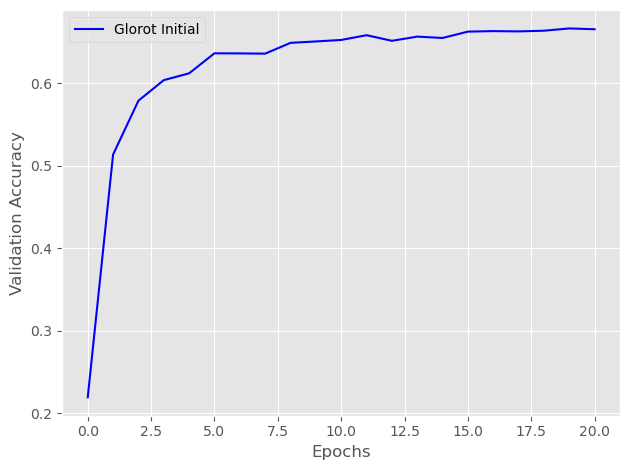

In [255]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, # poor starting learning rate!!
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn_better = TLP(**vals)
%time nn_better.fit(X_train_dummies, y_train, print_progress=1, XY_test=(X_test_dummies, y_test))

print_result(nn_better,X_train_dummies,y_train,X_test_dummies,y_test,title="Two-Layer Perceptron",color="blue")
plt.show()

## 3. Modeling

[1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.
[1 points] Repeat the previous step, adding support for a fourth layer.
[1 points] Repeat the previous step, adding support for a fifth layer. 
[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

In [28]:
"""
Only for Testing that the newly implemented Perceptrons work, used in oroiginal notebook
DELETE WHEN FINISHED TESTING
"""
# more diverse fashion MNIST data
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='fashion_t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

# important pre-processing steps!!
X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5


Rows: 60000, columns: 784
Rows: 10000, columns: 784


### 3.1: Three-Layer Perceptron Code
We added support for a third layer in the multi-layer perceptron. We have also added support for saving and plotting the magnitude of the gradient (average absolute values) after each layer for each epoch.

In [24]:
class ThreeLP:             
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        # This seems to do something with the child class, which no longer exists
        # super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # added this one

        self.cost_ = []
        self.score_ = []
        # get starting accuracy without training.
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            # Copies the testing data (X,y) to its respective places.
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            # Gets the initial Validation Accuracy (on test data)
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.update_w1_ = np.zeros(self.epochs)
        self.update_w2_ = np.zeros(self.epochs)
        self.update_w3_ = np.zeros(self.epochs)
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A_last = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                        self.W3,
                                                       self.b1,
                                                       self.b2,
                                                        self.b3
                                                      )
                
                cost = self._cost(A_last,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(
                    A1=A1, A2=A2, A3=A3, A_last=A_last, Z1=Z1, Z2=Z2, Z3=Z3,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3) # added params

                # Extra stuff for Average Magnitude
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                
                # simple momentum calculations
                rho_W1, rho_W2, rho_W3 = eta * gradW1, eta * gradW2, eta * gradW3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # added
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3 # added
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3 # added

                self.update_w1_[i] = np.mean(np.abs(eta * gradW1))
                self.update_w2_[i] = np.mean(np.abs(eta * gradW2))
                self.update_w3_[i] = np.mean(np.abs(eta * gradW3))
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
        
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        # print(f"Weights 1: init_bound {init_bound}, shape ({self.n_hidden}, {self.n_features_})")

        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden, 1))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3
    
    def _cost(self,A_last,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_last+1e-7)+(1-Y_enc)*np.log(1-A_last+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A_last, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        # A1, Z1, A2, Z2, A3, Z3, A_last
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = (A_last-Y_enc) # <- this is only line that changed
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A_last,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A_last)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A_last = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A_last

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A_last = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A_last, axis=0)
        return y_pred


### 3.2: Testing the Performance of the Three-Layer Perceptron

Epoch: 20/20

CPU times: user 1min 28s, sys: 7.77 s, total: 1min 36s
Wall time: 13.5 s
Three-Layer Perceptron :
Resubstitution acc: 0.8627166666666667
Validation acc: 0.8456


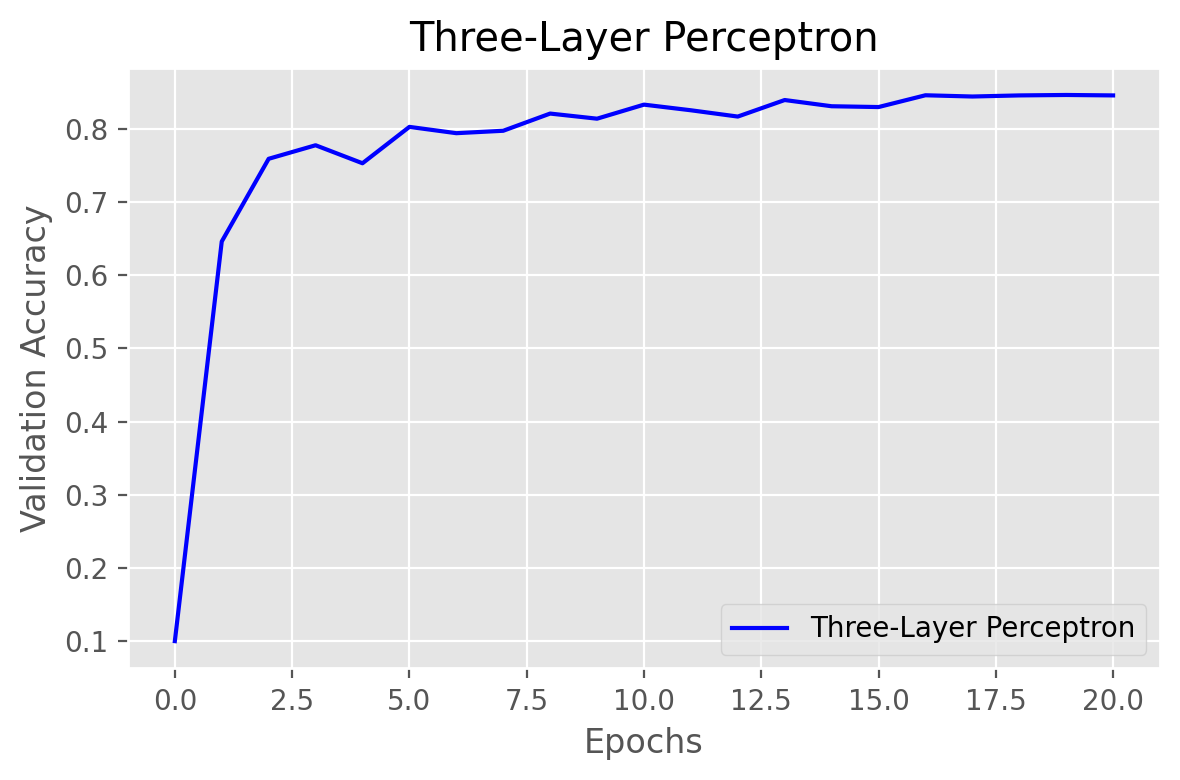

In [62]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001,
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn_three = ThreeLP(**vals)
%time nn_three.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_three,X_train,y_train,X_test,y_test,title="Three-Layer Perceptron",color="blue")
plt.show()

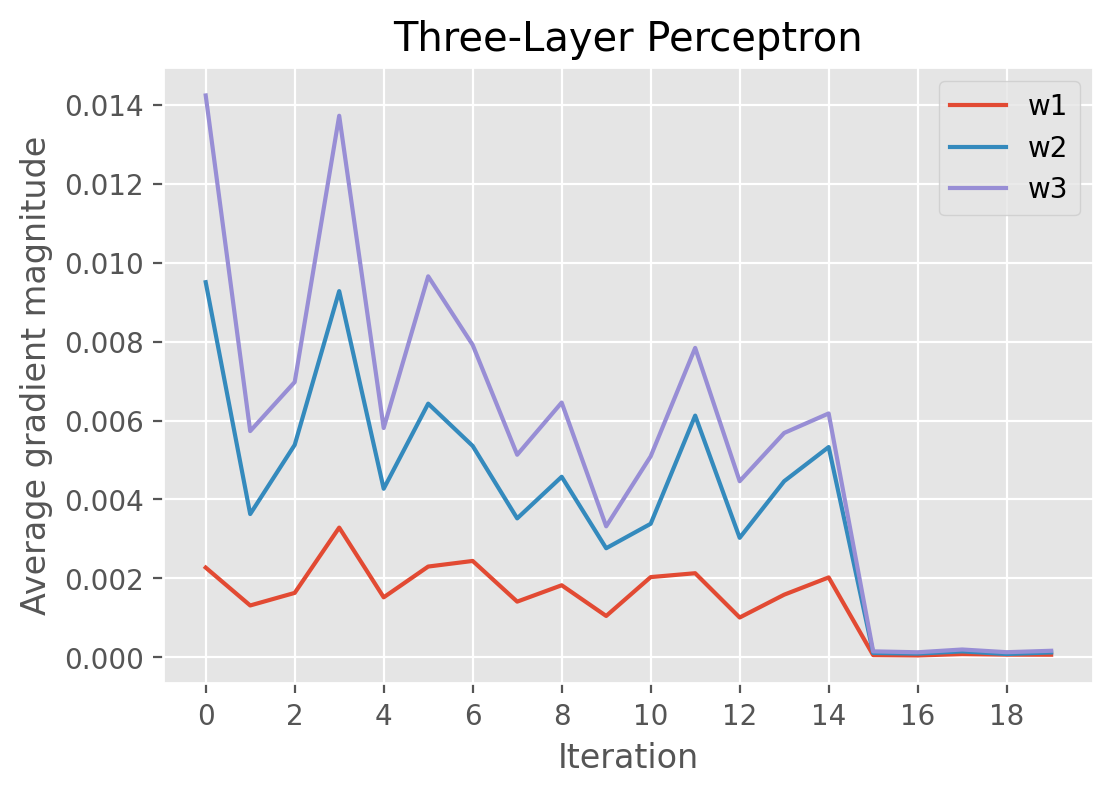

In [58]:
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
plt.plot(np.abs(nn_three.update_w1_[:]), label='w1')
plt.plot(np.abs(nn_three.update_w2_[:]), label='w2')
plt.plot(np.abs(nn_three.update_w3_[:]), label='w3')
plt.xticks(np.arange(0,20,2))
plt.legend()
plt.title("Three-Layer Perceptron")
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

### 3.3: Four-Layer Perceptron Code

In [19]:
class FourLP:             
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        # This seems to do something with the child class, which no longer exists
        # super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # added this one
        rho_W4_prev = np.zeros(self.W4.shape) # added this one

        self.cost_ = []
        self.score_ = []
        # get starting accuracy without training.
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            # Copies the testing data (X,y) to its respective places.
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            # Gets the initial Validation Accuracy (on test data)
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.update_w1_ = np.zeros(self.epochs)
        self.update_w2_ = np.zeros(self.epochs)
        self.update_w3_ = np.zeros(self.epochs)
        self.update_w4_ = np.zeros(self.epochs)
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A_last = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                        self.W3,
                                                        self.W4,
                                                       self.b1,
                                                       self.b2,
                                                        self.b3,
                                                        self.b4
                                                      )
                
                cost = self._cost(A_last,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4 = self._get_gradient(
                    A1=A1, A2=A2, A3=A3, A4=A4, A_last=A_last, 
                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4) # added params

                # Extra stuff for Average Magnitude
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))
                
                # simple momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # added
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # added
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3 # added
                self.b4 -= eta * gradb4 # added
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev = rho_W1, rho_W2, rho_W3, rho_W4 # added

                self.update_w1_[i] = np.mean(np.abs(eta * gradW1))
                self.update_w2_[i] = np.mean(np.abs(eta * gradW2))
                self.update_w3_[i] = np.mean(np.abs(eta * gradW3))
                self.update_w4_[i] = np.mean(np.abs(eta * gradW4))
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
        
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        # print(f"Weights 1: init_bound {init_bound}, shape ({self.n_hidden}, {self.n_features_})")

        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        
        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden, 1))
        b3 = np.zeros((self.n_hidden, 1))
        b4 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, b1, b2, b3, b4
    
    def _cost(self,A_last,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_last+1e-7)+(1-Y_enc)*np.log(1-A_last+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A_last, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        # A1, Z1, A2, Z2, A3, Z3, A_last
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V4 = (A_last-Y_enc) # <- this is only line that changed
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))
    
    def _cost(self,A_last,Y_enc,W1,W2,W3, W4):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A_last)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A_last = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A_last

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A_last = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4)
        y_pred = np.argmax(A_last, axis=0)
        return y_pred


### 3.4: Testing the Performance of the Four-Layer Perceptron

Epoch: 20/20

CPU times: user 2min 10s, sys: 8.32 s, total: 2min 18s
Wall time: 21.1 s
Four-Layer Perceptron :
Resubstitution acc: 0.8632166666666666
Validation acc: 0.8476


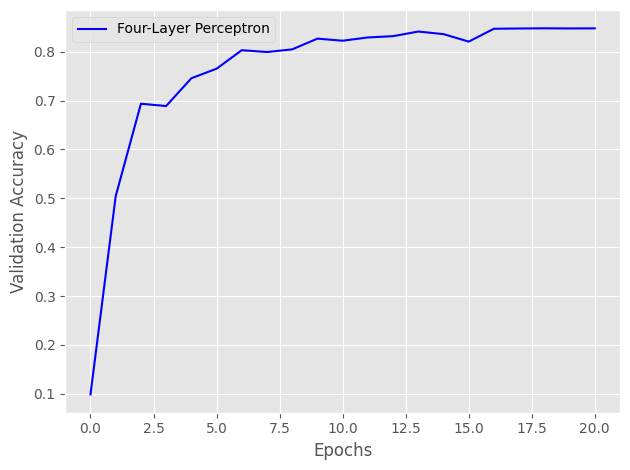

In [36]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001,
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn_four = FourLP(**vals)
%time nn_four.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_four,X_train,y_train,X_test,y_test,title="Four-Layer Perceptron",color="blue")
plt.show()

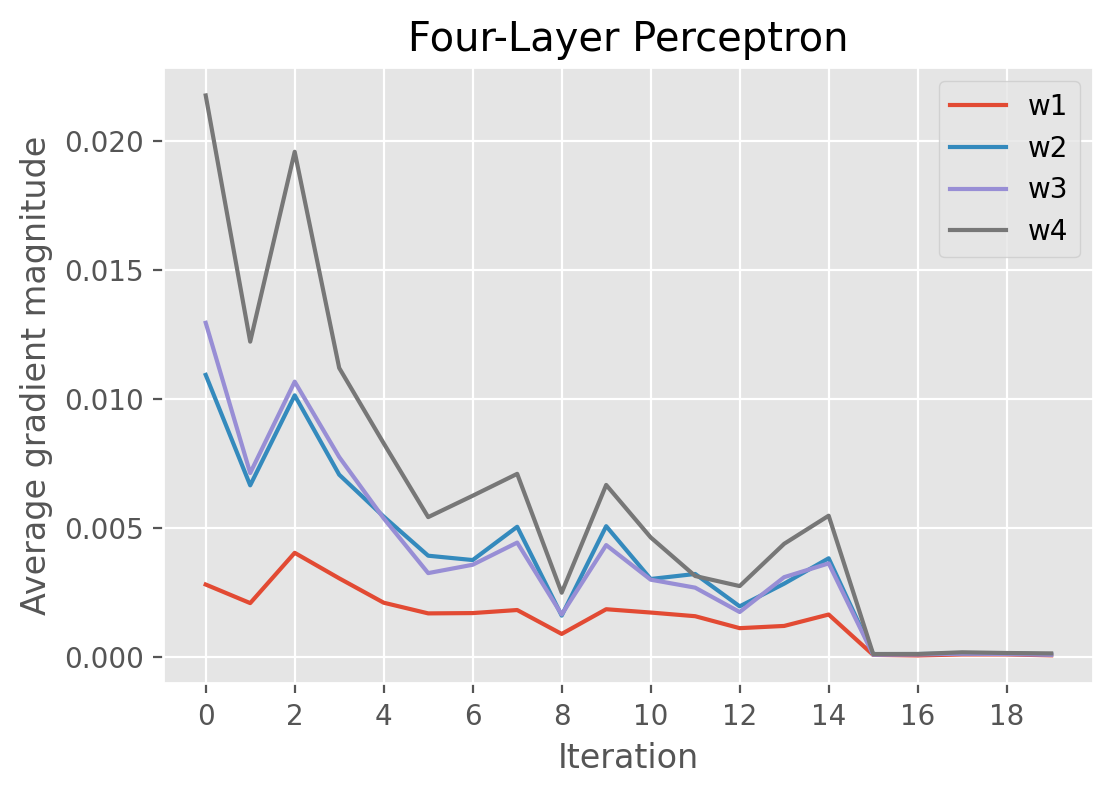

In [55]:
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
plt.plot(np.abs(nn_four.update_w1_[:]), label='w1')
plt.plot(np.abs(nn_four.update_w2_[:]), label='w2')
plt.plot(np.abs(nn_four.update_w3_[:]), label='w3')
plt.plot(np.abs(nn_four.update_w4_[:]), label='w4')
plt.xticks(np.arange(0,20,2))
plt.title("Four-Layer Perceptron")
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

### 3.5: Five-Layer Perceptron Code

In [11]:
class FiveLP:             
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        # This seems to do something with the child class, which no longer exists
        # super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # added this one
        rho_W4_prev = np.zeros(self.W4.shape) # added this one
        rho_W5_prev = np.zeros(self.W5.shape) # added this one

        self.cost_ = []
        self.score_ = []
        # get starting accuracy without training.
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            # Copies the testing data (X,y) to its respective places.
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            # Gets the initial Validation Accuracy (on test data)
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        self.update_w1_ = np.zeros(self.epochs)
        self.update_w2_ = np.zeros(self.epochs)
        self.update_w3_ = np.zeros(self.epochs)
        self.update_w4_ = np.zeros(self.epochs)
        self.update_w5_ = np.zeros(self.epochs)
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A_last = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                        self.W3,
                                                        self.W4,
                                                        self.W5,
                                                       self.b1,
                                                       self.b2,
                                                        self.b3,
                                                        self.b4,
                                                        self.b5
                                                      )
                
                cost = self._cost(A_last,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(
                    A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A_last=A_last, 
                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5) # added params

                # Extra stuff for Average Magnitude
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))
                self.grad_w5_[i] = np.mean(np.abs(gradW5))
                
                # simple momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4, eta * gradW5
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # added
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # added
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # added
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3 # added
                self.b4 -= eta * gradb4 # added
                self.b5 -= eta * gradb5 # added
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 # added

                self.update_w1_[i] = np.mean(np.abs(eta * gradW1))
                self.update_w2_[i] = np.mean(np.abs(eta * gradW2))
                self.update_w3_[i] = np.mean(np.abs(eta * gradW3))
                self.update_w4_[i] = np.mean(np.abs(eta * gradW4))
                self.update_w5_[i] = np.mean(np.abs(eta * gradW5))
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
        
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        # print(f"Weights 1: init_bound {init_bound}, shape ({self.n_hidden}, {self.n_features_})")

        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        
        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))

        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden, 1))
        b3 = np.zeros((self.n_hidden, 1))
        b4 = np.zeros((self.n_hidden, 1))
        b5 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5
    
    def _cost(self,A_last,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_last+1e-7)+(1-Y_enc)*np.log(1-A_last+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A_last, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        # A1, Z1, A2, Z2, A3, Z3, A_last
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = (A_last-Y_enc) # <- this is only line that changed
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A_last,Y_enc,W1,W2,W3, W4, W5):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A_last)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A_last = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A_last

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A_last = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A_last, axis=0)
        return y_pred


### 3.6: Testing the Performance of the Five-Layer Perceptron

Epoch: 20/20

CPU times: user 2min 17s, sys: 8.57 s, total: 2min 25s
Wall time: 21.5 s
Five-Layer Perceptron :
Resubstitution acc: 0.8573833333333334
Validation acc: 0.8407


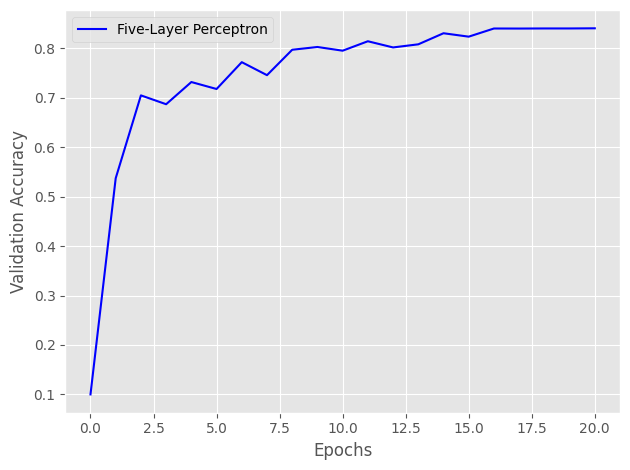

In [38]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001,
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn_five = FiveLP(**vals)
%time nn_five.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_five,X_train,y_train,X_test,y_test,title="Five-Layer Perceptron",color="blue")
plt.show()

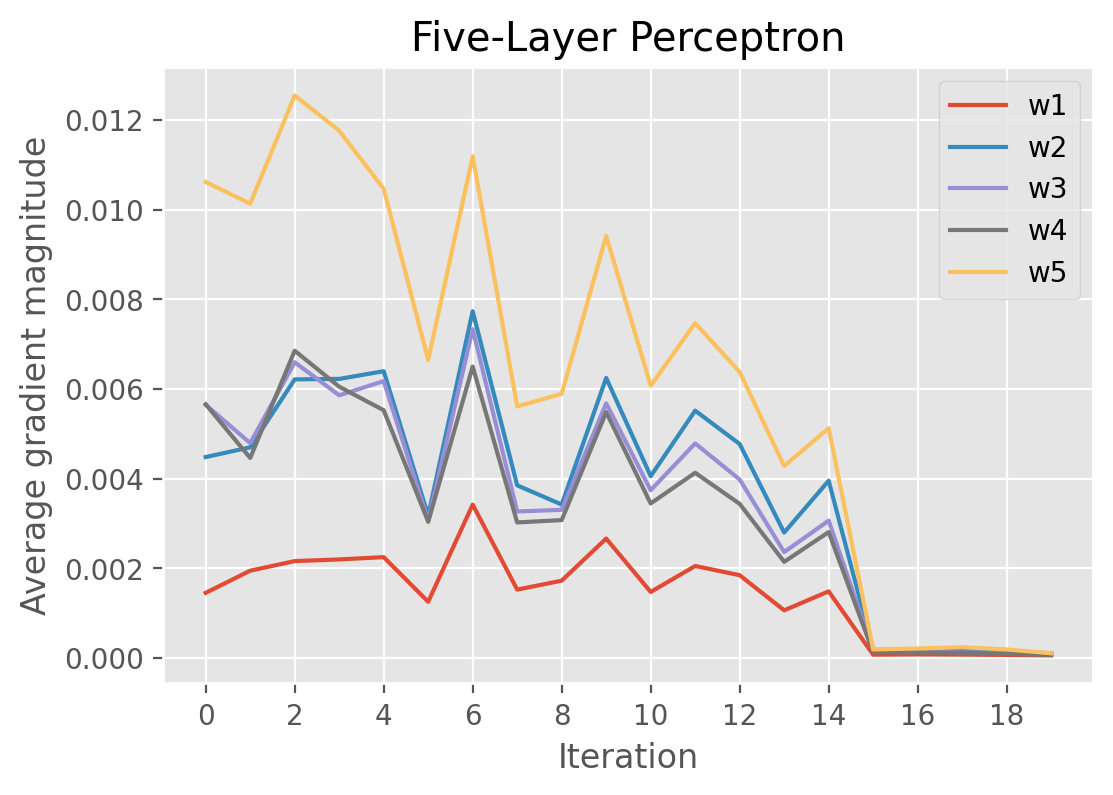

In [52]:
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
plt.plot(np.abs(nn_five.update_w1_[:]), label='w1')
plt.plot(np.abs(nn_five.update_w2_[:]), label='w2')
plt.plot(np.abs(nn_five.update_w3_[:]), label='w3')
plt.plot(np.abs(nn_five.update_w4_[:]), label='w4')
plt.plot(np.abs(nn_five.update_w5_[:]), label='w5')
plt.title("Five-Layer Perceptron")
plt.xticks(np.arange(0,20,2))
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

### 3.7: RMSProp + Five-Layer Perceptron

Root Mean Square Propagation (RMSProp) is an adaptive learning strategy that emerged from practical use rather than formal research. Unlike other methods like Adagrad, RMSProp did not suffer from the diminishing learning rate problem since it updates its learning rate using both the current and previous gradient. This ensures that the learning rate does not drop too steeply from step to step.

Sources: [Kaggle](https://www.kaggle.com/discussions/getting-started/455397), [Understanding RMSProp](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)

In [114]:
class FiveLP_RMSProp(FiveLP):

    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # added this one
        rho_W4_prev = np.zeros(self.W4.shape) # added this one
        rho_W5_prev = np.zeros(self.W5.shape) # added this one

        # adaptive G for entire gradient
        G1_prev = np.zeros(self.W1.shape) # for adaptive
        G2_prev = np.zeros(self.W2.shape) # for adaptive
        G3_prev = np.zeros(self.W3.shape)
        G4_prev = np.zeros(self.W4.shape)
        G5_prev = np.zeros(self.W5.shape)
        
        V1 = np.zeros(self.W1.shape)
        V2 = np.zeros(self.W2.shape)
        V3 = np.zeros(self.W3.shape)
        V4 = np.zeros(self.W4.shape)
        V5 = np.zeros(self.W5.shape)
        
        M1_next = np.zeros(self.W1.shape)
        M2_next = np.zeros(self.W2.shape)
        M3_next = np.zeros(self.W3.shape)
        M4_next = np.zeros(self.W4.shape)
        M5_next = np.zeros(self.W5.shape)
        
        self.cost_ = []
        self.score_ = []
        # get starting accuracy without training.
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            # Copies the testing data (X,y) to its respective places.
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            # Gets the initial Validation Accuracy (on test data)
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        self.update_w1_ = np.zeros(self.epochs)
        self.update_w2_ = np.zeros(self.epochs)
        self.update_w3_ = np.zeros(self.epochs)
        self.update_w4_ = np.zeros(self.epochs)
        self.update_w5_ = np.zeros(self.epochs)
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A_last = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                        self.W3,
                                                        self.W4,
                                                        self.W5,
                                                       self.b1,
                                                       self.b2,
                                                        self.b3,
                                                        self.b4,
                                                        self.b5
                                                      )
                
                cost = self._cost(A_last,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(
                    A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A_last=A_last, 
                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5) # added params

                # Extra stuff for Average Magnitude
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))
                self.grad_w5_[i] = np.mean(np.abs(gradW5))

                """
                Beginning of Changes
                """
                # momentum and adaptation calculations
                # Eta-grad implementation:
                # M_next = 0 at the start
        
                # Update for W1
                V1 = self.alpha * V1 + (1 - self.alpha) * gradW1 * gradW1
                rho_W1 = eta / np.sqrt(V1 + 1e-7) * gradW1
                
                # Update for W2
                V2 = self.alpha * V2 + (1 - self.alpha) * gradW2 * gradW2
                rho_W2 = eta / np.sqrt(V2 + 1e-7) * gradW2
                
                # Update for W3
                V3 = self.alpha * V3 + (1 - self.alpha) * gradW3 * gradW3
                rho_W3 = eta / np.sqrt(V3 + 1e-7) * gradW3
                
                # Update for W4
                V4 = self.alpha * V4 + (1 - self.alpha) * gradW4 * gradW4
                rho_W4 = eta / np.sqrt(V4 + 1e-7) * gradW4
                
                # Update for W5
                V5 = self.alpha * V5 + (1 - self.alpha) * gradW5 * gradW5
                rho_W5 = eta / np.sqrt(V5 + 1e-7) * gradW5
        
                # G1 = gradW1*gradW1 + self.alpha*G1_prev + 1e-7
                # G2 = gradW2*gradW2 + self.alpha*G2_prev + 1e-7
                # G3 = gradW3*gradW3 + self.alpha*G3_prev + 1e-7
                # G4 = gradW4*gradW4 + self.alpha*G4_prev + 1e-7
                # G5 = gradW5*gradW5 + self.alpha*G5_prev + 1e-7
                
                # # momentum and adagrad
                # rho_W1 = eta * gradW1/np.sqrt(G1)
                # rho_W2 = eta * gradW2/np.sqrt(G2)
                # rho_W3 = eta * gradW3/np.sqrt(G3)
                # rho_W4 = eta * gradW4/np.sqrt(G4)
                # rho_W5 = eta * gradW5/np.sqrt(G5)

                """
                End of Changes
                """

                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # added
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # added
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # added
                
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3 # added
                self.b4 -= eta * gradb4 # added
                self.b5 -= eta * gradb5 # added
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 # added
                # G1_prev, G2_prev, G3_prev, G4_prev, G5_prev = G1, G2, G3, G4, G5
                # V1_prev, V2_prev, V3_prev, V4_prev, V5_prev = V1, V2, V3, V4, V5


                self.update_w1_[i] = np.mean(np.abs(eta * gradW1))
                self.update_w2_[i] = np.mean(np.abs(eta * gradW2))
                self.update_w3_[i] = np.mean(np.abs(eta * gradW3))
                self.update_w4_[i] = np.mean(np.abs(eta * gradW4))
                self.update_w5_[i] = np.mean(np.abs(eta * gradW5))
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

### 3.8: Testing the Performance of RMSProp + Five-Layer Perceptron

Epoch: 20/20

CPU times: user 4min 20s, sys: 8.93 s, total: 4min 29s
Wall time: 39.9 s
Five-Layer Perceptron + Ada Delta :
Resubstitution acc: 0.9000833333333333
Validation acc: 0.8661


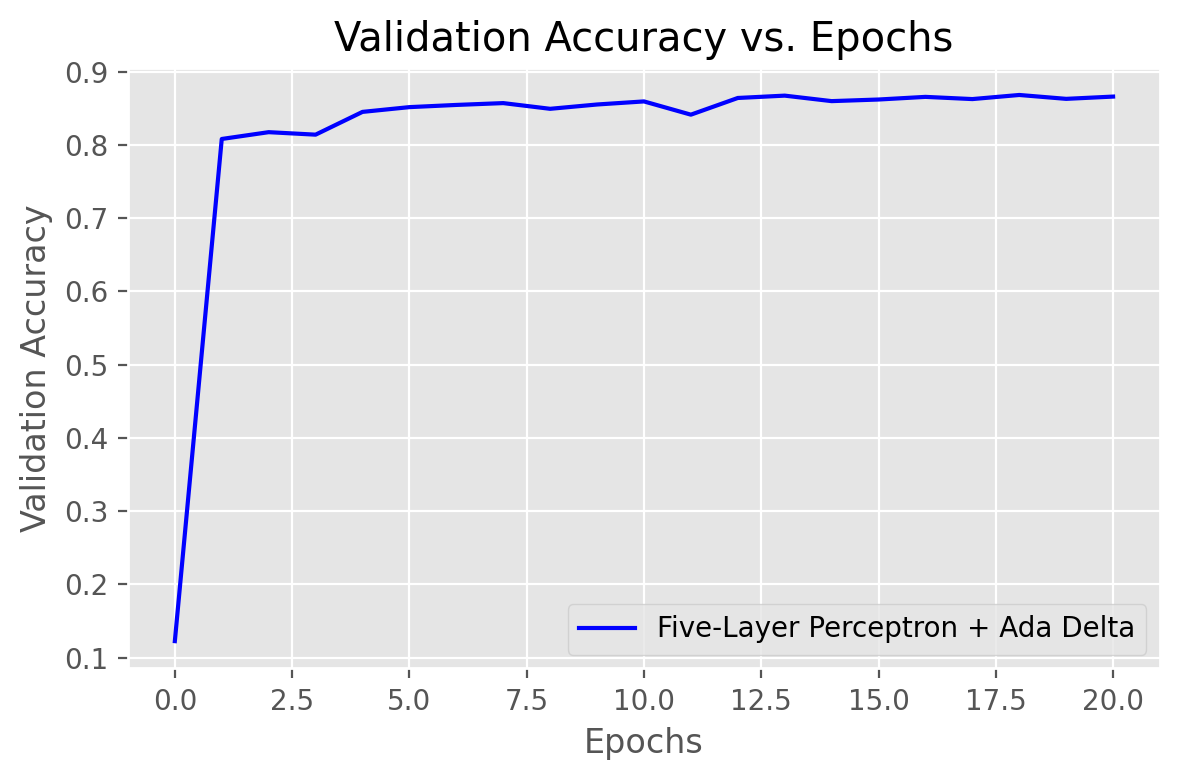

In [111]:
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':20, 'eta':0.005, 
         'alpha':0.1, 'decrease_const':0.1,
         'decrease_iter':20,
         'minibatches':len(X_train)/256,
         'shuffle':True,'random_state':1}

nn_five_rms = FiveLP_RMSProp(**vals)
%time nn_five_rms.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_five_rms,X_train,y_train,X_test,y_test,title="Five-Layer Perceptron + RMS Prop",color="blue")
plt.show()

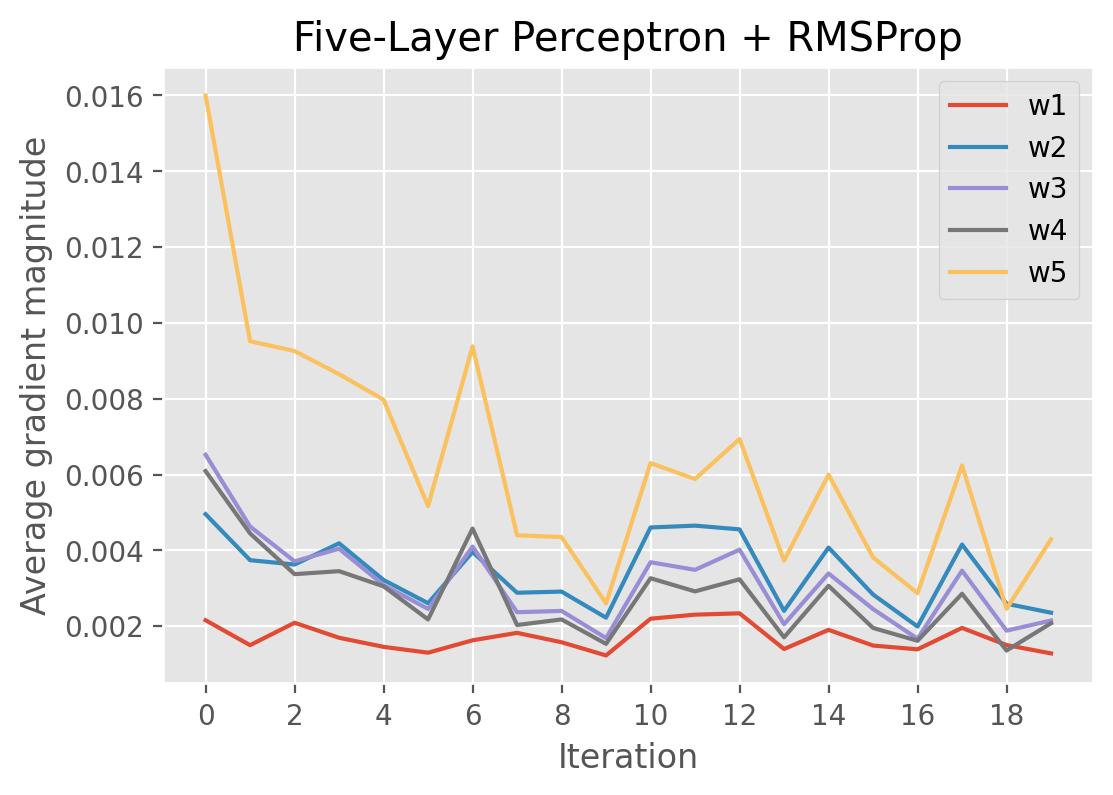

In [113]:
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
plt.plot(np.abs(nn_five_rms.update_w1_[:]), label='w1')
plt.plot(np.abs(nn_five_rms.update_w2_[:]), label='w2')
plt.plot(np.abs(nn_five_rms.update_w3_[:]), label='w3')
plt.plot(np.abs(nn_five_rms.update_w4_[:]), label='w4')
plt.plot(np.abs(nn_five_rms.update_w5_[:]), label='w5')
plt.title("Five-Layer Perceptron + RMSProp")
plt.xticks(np.arange(0,20,2))
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

## 4. Extra Work: Six-Layer Perceptron

### 4.1: Six-Layer Perceptron Code

In [64]:
class SixLP:             
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        # This seems to do something with the child class, which no longer exists
        # super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.W6, self.b1, self.b2, self.b3, self.b4, self.b5, self.b6 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # added this one
        rho_W4_prev = np.zeros(self.W4.shape) # added this one
        rho_W5_prev = np.zeros(self.W5.shape) # added this one
        rho_W6_prev = np.zeros(self.W6.shape) # added this one

        self.cost_ = []
        self.score_ = []
        # get starting accuracy without training.
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            # Copies the testing data (X,y) to its respective places.
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            # Gets the initial Validation Accuracy (on test data)
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)
        self.grad_w6_ = np.zeros(self.epochs)
        self.update_w1_ = np.zeros(self.epochs)
        self.update_w2_ = np.zeros(self.epochs)
        self.update_w3_ = np.zeros(self.epochs)
        self.update_w4_ = np.zeros(self.epochs)
        self.update_w5_ = np.zeros(self.epochs)
        self.update_w6_ = np.zeros(self.epochs)
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6, Z6, A_last = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                        self.W3,
                                                        self.W4,
                                                        self.W5,
                                                        self.W6,
                                                       self.b1,
                                                       self.b2,
                                                        self.b3,
                                                        self.b4,
                                                        self.b5,
                                                        self.b6
                                                      )
                
                cost = self._cost(A_last,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5,self.W6)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradW6, gradb1, gradb2, gradb3, gradb4, gradb5, gradb6 = self._get_gradient(
                    A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, A_last=A_last, 
                    Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, Z6=Z6,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5,W6=self.W6) # added params

                # Extra stuff for Average Magnitude
                self.grad_w1_[i] = np.mean(np.abs(gradW1))
                self.grad_w2_[i] = np.mean(np.abs(gradW2))
                self.grad_w3_[i] = np.mean(np.abs(gradW3))
                self.grad_w4_[i] = np.mean(np.abs(gradW4))
                self.grad_w5_[i] = np.mean(np.abs(gradW5))
                self.grad_w6_[i] = np.mean(np.abs(gradW6))
                
                # simple momentum calculations
                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5, rho_W6 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4, eta * gradW5, eta * gradW6
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # added
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # added
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # added
                self.W6 -= (rho_W6 + (self.alpha * rho_W6_prev)) # added
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3 # added
                self.b4 -= eta * gradb4 # added
                self.b5 -= eta * gradb5 # added
                self.b6 -= eta * gradb6 # added
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev, rho_W6_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5, rho_W6 # added

                self.update_w1_[i] = np.mean(np.abs(eta * gradW1))
                self.update_w2_[i] = np.mean(np.abs(eta * gradW2))
                self.update_w3_[i] = np.mean(np.abs(eta * gradW3))
                self.update_w4_[i] = np.mean(np.abs(eta * gradW4))
                self.update_w5_[i] = np.mean(np.abs(eta * gradW5))
                self.update_w6_[i] = np.mean(np.abs(eta * gradW6))
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
        
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        # print(f"Weights 1: init_bound {init_bound}, shape ({self.n_hidden}, {self.n_features_})")

        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        
        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))

        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))

        # Assuming we keep the number of neurons the same for each hidden layer.
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W6 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_hidden, 1))
        b3 = np.zeros((self.n_hidden, 1))
        b4 = np.zeros((self.n_hidden, 1))
        b5 = np.zeros((self.n_hidden, 1))
        b6 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, W4, W5, W6, b1, b2, b3, b4, b5, b6
    
    def _cost(self,A_last,Y_enc,W1,W2,W3,W4,W5,W6):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_last+1e-7)+(1-Y_enc)*np.log(1-A_last+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5, W6)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, A_last, Z1, Z2, Z3, Z4, Z5, Z6, Y_enc, W1, W2, W3, W4, W5, W6):
        # A1, Z1, A2, Z2, A3, Z3, A_last
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V6 = (A_last-Y_enc) # <- this is only line that changed
        V5 = A6*(1-A6)*(W6.T @ V6)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        gradW6 = V6 @ A6.T
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb6 = np.sum(V6, axis=1).reshape((-1,1))
        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C
        gradW6 += W6 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradW6, gradb1, gradb2, gradb3, gradb4, gradb5, gradb6

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5, W6):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2) + np.mean(W6[:, 1:] ** 2))
    
    def _cost(self,A_last,Y_enc,W1,W2,W3, W4, W5, W6):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A_last)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5, W6)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4, W5, W6, b1, b2, b3, b4, b5, b6):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        Z6 = W6 @ A6 + b6
        A_last = self._sigmoid(Z6)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6, Z6, A_last

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, _, _, A_last = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5, self.W6, self.b1, self.b2, self.b3, self.b4, self.b5, self.b6)
        y_pred = np.argmax(A_last, axis=0)
        return y_pred


### 4.2: Testing the Performance of the Six-Layer Perceptron

Epoch: 20/20

CPU times: user 2min 37s, sys: 10.5 s, total: 2min 48s
Wall time: 25.8 s
Six-Layer Perceptron :
Resubstitution acc: 0.85755
Validation acc: 0.8421


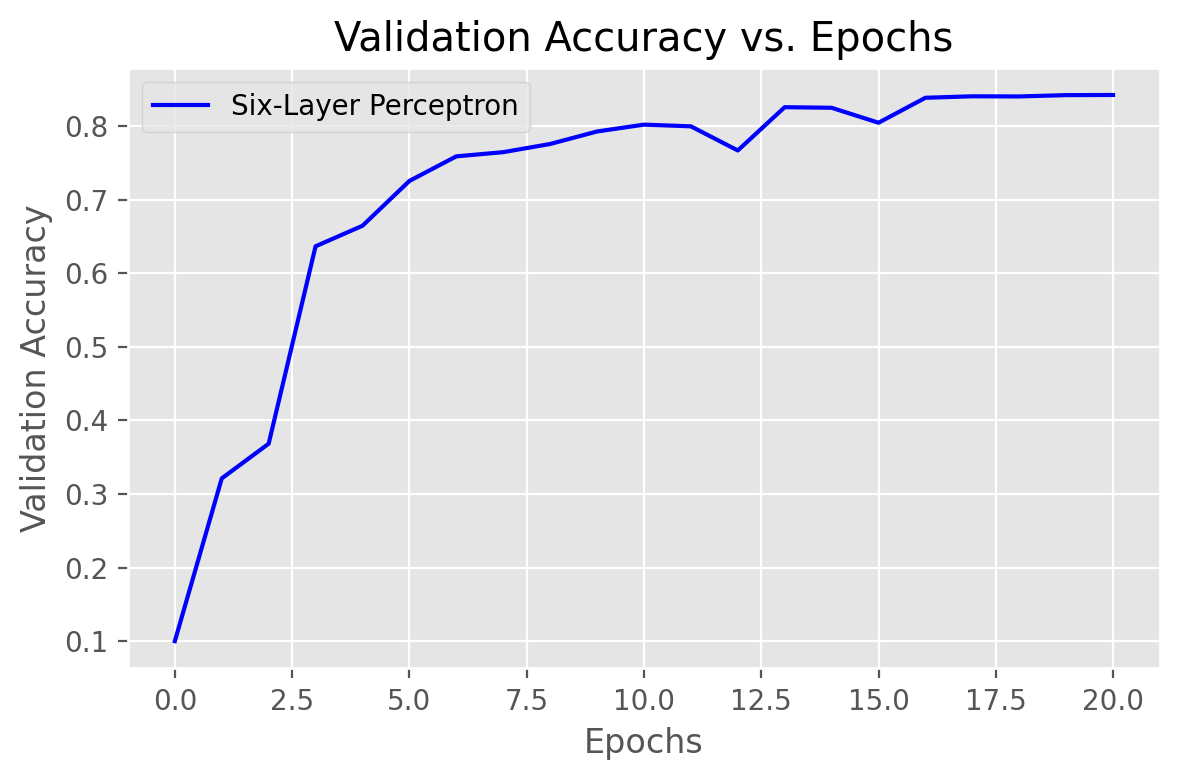

In [65]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001,
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn_six = SixLP(**vals)
%time nn_six.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_six,X_train,y_train,X_test,y_test,title="Six-Layer Perceptron",color="blue")
plt.show()

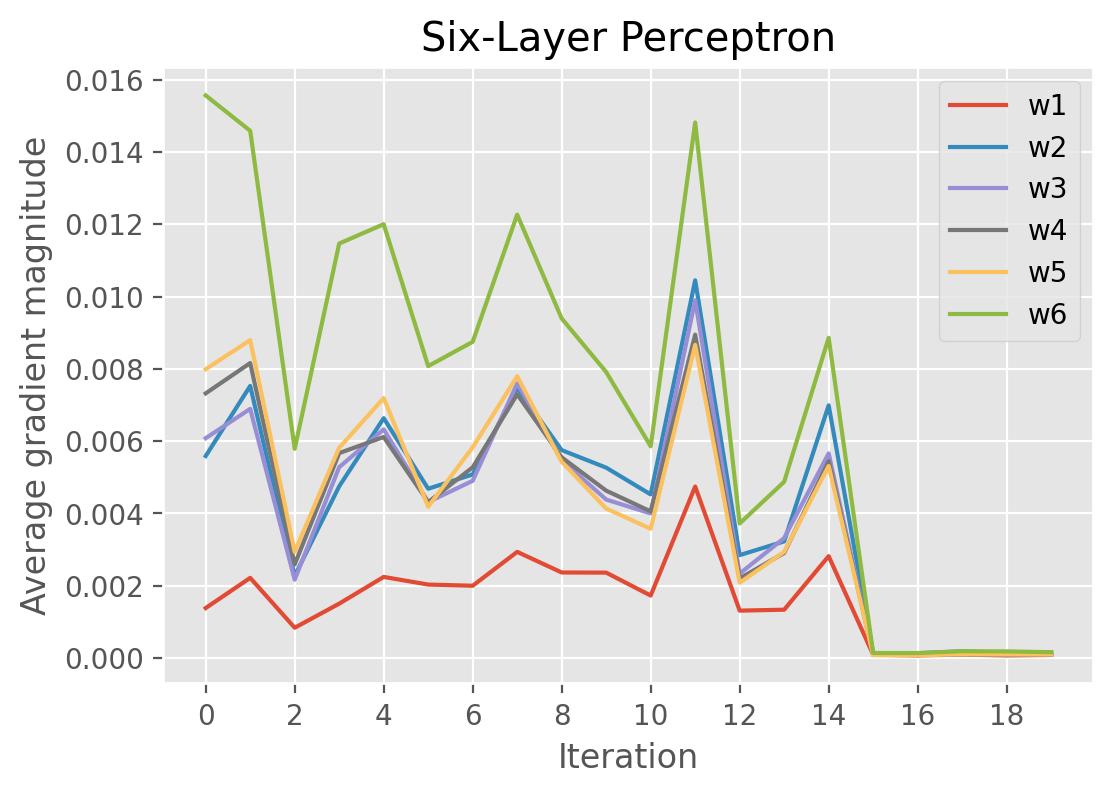

In [66]:
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
plt.plot(np.abs(nn_six.update_w1_[:]), label='w1')
plt.plot(np.abs(nn_six.update_w2_[:]), label='w2')
plt.plot(np.abs(nn_six.update_w3_[:]), label='w3')
plt.plot(np.abs(nn_six.update_w4_[:]), label='w4')
plt.plot(np.abs(nn_six.update_w5_[:]), label='w5')
plt.plot(np.abs(nn_six.update_w6_[:]), label='w6')
plt.xticks(np.arange(0,20,2))
plt.legend()
plt.title("Six-Layer Perceptron")
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()